In [100]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator, YearLocator
from sklearn import tree
from sklearn.ensemble.forest import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store_info = pd.read_csv(filename_store, header=0, low_memory=False)

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store_info}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask].tolist())
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
# print_missing_stats()

### Filling missing values

In [101]:
# print(test[test.Open.isnull()])
test.ix[test.Open.isnull(), 'Open'] = 1

store_info.ix[store_info.CompetitionDistance.isnull(),
         'CompetitionDistance'] = 0
store_info.ix[store_info.CompetitionOpenSinceMonth.isnull(),
         'CompetitionOpenSinceMonth'] = 0
store_info.ix[store_info.CompetitionOpenSinceYear.isnull(),
         'CompetitionOpenSinceYear'] = 0
store_info.ix[store_info.Promo2SinceWeek.isnull(),
         'Promo2SinceWeek'] = 0
store_info.ix[store_info.Promo2SinceYear.isnull(),
         'Promo2SinceYear'] = 0

promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))
# print_missing_stats()
del promo_intervals

### Plotting all sales by day of week and store

In [102]:
# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

# open_df = train[train.Open == 1]
# for day_of_week in range(1, 8):
#     custom_df = open_df[open_df.DayOfWeek == day_of_week] 
#     gp_store = custom_df.groupby('Store')

#     for store, group in gp_store:
#         axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

#     gp_date = custom_df.groupby('Date')

#     ts_mean = gp_date['Sales'].mean()
#     ts_median = gp_date['Sales'].median()
#     ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
#     ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
# # pl.savefig('all_stores_and_median.png', format='png')
# del axes,fig, ts_mean, custom_df, gp_date, gp_store, open_df, ts_median

### Plotting mean of sales by day of week with different values of categorical features

In [103]:
# def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
#     string_school = 'NO SchoolHoliday. '
#     string_state = 'NO StateHoliday. '
#     string_promo = 'NO Promo. '
#     if school_holiday == 1:
#         string_school = string_school[3:]
#     if promo_flag:
#         string_promo = string_promo[3:]
#     if state_holiday != '0':
#         string_state = {'a': 'PublicHoliday. ',
#                         'b': 'EasterHoliday. ',
#                         'c':'Christmas. '}[state_holiday]
#     string_stores = '(' + str(n_stores) + ' stores)'
#     return string_school + string_state + string_promo + string_stores

# fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

# open_df = train[train.Open == 1]
# for day_of_week in range(1, 8):
#     day_df = open_df[open_df.DayOfWeek == day_of_week]
#     for school_holiday in [0, 1]:
#         school_df = day_df[day_df.SchoolHoliday == school_holiday]
#         for state_holiday in ['0', 'a', 'b', 'c']:
#             state_df = school_df[school_df.StateHoliday == state_holiday]
#             for promo_flag in [0, 1]:
#                 custom_df = state_df[state_df.Promo == promo_flag]
#                 if not custom_df.empty:
#                     gp_date = custom_df.groupby('Date')
#                     gp_store = custom_df.groupby('Store')
                
#                     ts_mean = gp_date.Sales.mean()
#                     axes[day_of_week - 1].plot(ts_mean.index, ts_mean, 'v--', 
#                                  label=construct_label_name(school_holiday, state_holiday,
#                                                             promo_flag, len(gp_store)))
    
                
#     custom_df = day_df
#     gp_date = custom_df.groupby('Date')
#     gp_store = custom_df.groupby('Store')
#     ts_mean = gp_date.Sales.mean()
#     ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1],
#                  label='mean (' + str(len(gp_store)) + ' stores)')
#     axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
#     axes[day_of_week - 1].legend()
#     axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
#     axes[day_of_week - 1].grid(True)
    
    
# # pl.savefig('median_decomposition.png', format='png')
# del axes,fig, ts_mean, custom_df, gp_date, gp_store, open_df, day_df, school_df, state_df

### Constructing train data

In [104]:
date_range_train = pd.date_range('2013-01-01', '2015-06-13')
date_range_test = pd.date_range('2015-06-14', '2015-07-31')

# date_range_train = pd.date_range('2013-01-01', '2014-07-31').union(pd.date_range('2014-09-18', '2015-07-31'))
# date_range_test = pd.date_range('2014-08-01', '2014-09-17')

validation = False
train = train[train.Open == 1]
if validation:
    train_date_range = train[train.Date.isin(date_range_train)]
else:
    train_date_range = train
    

train_features = ['Store', 'DayOfWeek', 'Date', 'Promo']
train_date_range = train_date_range[['Customers'] + train_features + ['Sales']]

def merge_with_store(data, store_info):    
    store_features = ['Store', 'StoreType', 'Assortment','CompetitionDistance', 
                      'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    return pd.merge(data, store_info[store_features], on='Store', how='left')

train_date_range = merge_with_store(train_date_range, store_info)

train_date_range['Day'] = train_date_range.Date.map(lambda d: d.day)
# train_date_range['Month'] = train_date_range.Date.map(lambda d: d.month)
# train_date_range['Year'] = train_date_range.Date.map(lambda d: d.year)
datetime_train = pd.datetime(2015, 9, 18)
train_date_range['DiffToday'] = ((datetime_train - train_date_range.Date)
                                 / np.timedelta64(1, 'D')).astype(int)
train_date_range['DiffNewYear'] = train_date_range.Date.map(lambda d: (min(d - pd.datetime(d.year, 1, 1),
                              pd.datetime(d.year + 1, 12, 31) - d)
                          / np.timedelta64(1, 'D')).astype(int))
train_date_range['DiffFoolDay'] = train_date_range.Date.map(lambda d: ((d - pd.datetime(d.year, 4, 1))
                                                                       / np.timedelta64(1, 'D')).astype(int))
del train_date_range['Date']
    
holiday_encoder, storetype_encoder, assortment_encoder = LabelEncoder(), LabelEncoder(), LabelEncoder()
holiday_encoder.fit(['0', 'a', 'b', 'c'])
storetype_encoder.fit(['a', 'b', 'c', 'd'])
assortment_encoder.fit(['a', 'b', 'c'])
    
# train_date_range.StateHoliday = holiday_encoder.transform(train_date_range.StateHoliday)
train_date_range.StoreType = storetype_encoder.transform(train_date_range.StoreType)
train_date_range.Assortment = assortment_encoder.transform(train_date_range.Assortment)

data_train_labels = np.array(train_date_range.Sales)
del train_date_range['Sales']
features = list(train_date_range.columns[1:])
print(features)
print('Number of features =', len(features))
data_train = np.array(train_date_range)
del train_date_range
print('\nConstructed data_train')

['Store', 'DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Day', 'DiffToday', 'DiffNewYear', 'DiffFoolDay']
Number of features = 15

Constructed data_train


### Constructing test data

In [105]:
def construct_test(data, holiday_encoder, storetype_encoder, assortment_encoder):
    temp = merge_with_store(data[[x for x in data.columns if x in train_features]], store_info)
#     temp.StateHoliday = holiday_encoder.transform(temp.StateHoliday)
    temp.StoreType = storetype_encoder.transform(temp.StoreType)
    temp.Assortment = assortment_encoder.transform(temp.Assortment)
    temp['Day'] = temp.Date.map(lambda d: d.day)
#     temp['Month'] = temp.Date.map(lambda d: d.month)
#     temp['Year'] = temp.Date.map(lambda d: d.year)
    temp['DiffToday'] = ((pd.to_datetime('2015-09-18') - temp.Date)
                                 / np.timedelta64(1, 'D')).astype(int)
    temp['DiffNewYear'] = temp.Date.map(lambda d: (min(d - pd.datetime(d.year, 1, 1),
                              pd.datetime(d.year + 1, 12, 31) - d)
                          / np.timedelta64(1, 'D')).astype(int))
    temp['DiffFoolDay'] = temp.Date.map(lambda d: ((d - pd.datetime(d.year, 4, 1))
                                                                       / np.timedelta64(1, 'D')).astype(int))
    del temp['Date']
    print(list(temp.columns))
    print('Number of features =', len(temp.columns))
    return np.array(temp)

if validation:
    local_test = train[train_features + ['Sales']]
    local_test = local_test[local_test.Date.isin(date_range_test)]
    local_test_labels = np.asarray(local_test.Sales)
    local_test = construct_test(local_test,
                                holiday_encoder, storetype_encoder, assortment_encoder)
    print('Constructed local_test')
else:
    data_test = construct_test(test, holiday_encoder, storetype_encoder, assortment_encoder)
    print('Constructed data_test')
    
# customers = data_train[:, 0]
data_train = data_train[:, 1:]
# df_customers = train[['Customers', 'Sales']]
# df_customers = df_customers.groupby('Customers').Sales.mean()    
# alpha = 0.15
# compound_train_labels = (1 - alpha) * data_train_labels + alpha * df_customers.loc[customers]
# del df_customers, customers
compound_train_labels = data_train_labels

test = test[['Id', 'Open']]
del date_range_test, date_range_train, train, store_info

['Store', 'DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Day', 'DiffToday', 'DiffNewYear', 'DiffFoolDay']
Number of features = 15
Constructed data_test


### Predicting

 0 (feature  5): CompetitionDistance Importance = 0.19518
 1 (feature  0): Store Importance = 0.15323
 2 (feature  2): Promo Importance = 0.15308
 3 (feature  7): CompetitionOpenSinceYear Importance = 0.07312
 4 (feature  1): DayOfWeek Importance = 0.07165
 5 (feature  6): CompetitionOpenSinceMonth Importance = 0.06805
 6 (feature  3): StoreType Importance = 0.04005
 7 (feature  9): Promo2SinceYear Importance = 0.03747
 8 (feature  8): Promo2SinceWeek Importance = 0.03522
 9 (feature 12): DiffToday Importance = 0.03380
10 (feature 14): DiffFoolDay Importance = 0.03254
11 (feature 13): DiffNewYear Importance = 0.03104
12 (feature 11): Day Importance = 0.03080
13 (feature  4): Assortment Importance = 0.02591
14 (feature 10): PromoInterval Importance = 0.01886

Result was written to prediction.csv


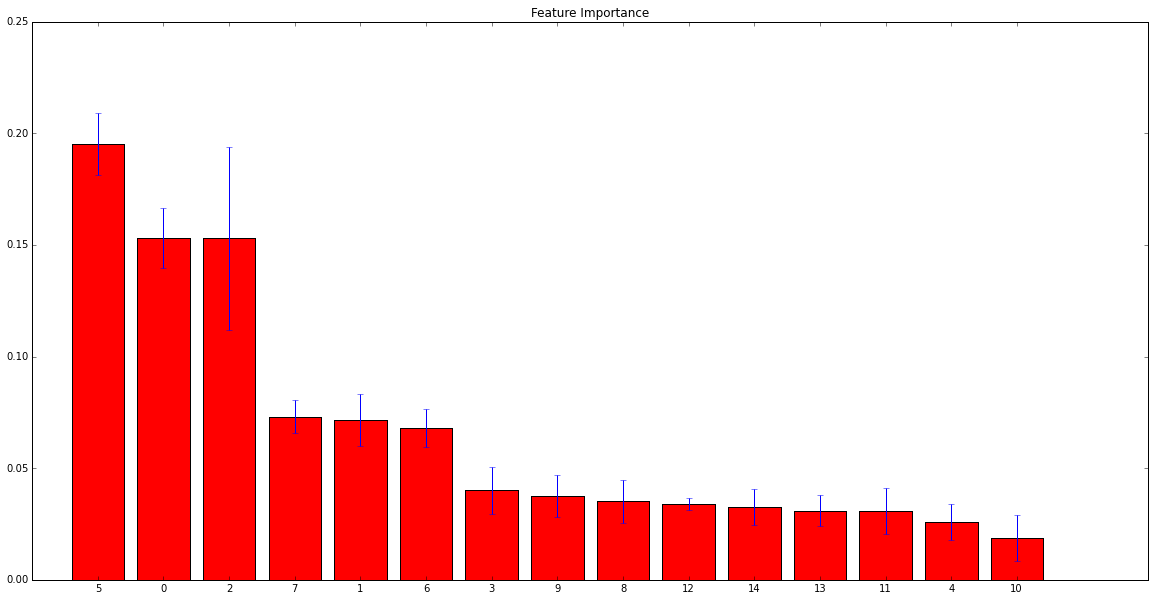

In [106]:
def visualize_feature_importances(clf, features):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    sorted_indices = np.argsort(importances)[::-1]
    for i, k in enumerate(sorted_indices):
        print('%2d (feature %2d):' % (i, k), features[k], 'Importance = %.5f' % importances[k])
    pl.figure(figsize=(20,10))
    pl.title('Feature Importance')
    pl.bar(range(len(features)), importances[sorted_indices], 
           color='r', yerr=2*std[sorted_indices], align='center')
    pl.xticks(range(len(features)), sorted_indices)
    pl.xlim([-1, len(features) + 1])
#     pl.savefig('feature_importance.png', format='png')
    
def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    y = test_labels[mask]
    y_hat = predicted_labels[mask]
    return np.sqrt(np.mean(((y - y_hat)/y)**2))

def visualize_RMSPE(test_labels, predicted_labels, step = 0.05):
    for i in np.arange(0, 1, step):
        pl.figure(figsize=(20,7))
        pl.plot(test_labels[i*len(test_labels):(i+step)*len(test_labels)],
                'b.', label='real')
        pl.plot(predicted_labels[i*len(predicted_labels):(i+step)*len(predicted_labels)],
                'r.', label='predicted')
        pl.legend()

rmspe_s, alphas = [], []
min_rmspe, min_alpha = 1., 0.

# grid_space = np.asarray(np.exp(np.linspace(2.2, 4.4, 20)), dtype=int)
grid_space = [0.5]
for alpha in grid_space:
    # clf = tree.DecisionTreeRegressor()
    clf = RandomForestRegressor(n_estimators=31, n_jobs=-1, min_samples_leaf=2, max_features=0.5) # 0.138 with log
    
    clf.fit(data_train, np.log(compound_train_labels + 1))

    if len(grid_space) <= 1:
        visualize_feature_importances(clf, features)
#         visualize_RMSPE(local_test_labels, predicted_test_labels)
    else:
        print('trying alpha =', alpha, end='\t')
        
    if validation:
        predicted_test_labels = np.exp(clf.predict(local_test)) - 1
        loss_score = compute_RMSPE(local_test_labels, predicted_test_labels)
        print('RMSPE on date_range_test =', loss_score)
        if loss_score <= min_rmspe:
            min_rmspe = loss_score
            min_alpha = alpha
        alphas.append(alpha)
        rmspe_s.append(loss_score)

    elif len(grid_space) <= 1:
        data_test_labels = np.exp(clf.predict(data_test)) - 1
        test['Sales'] = data_test_labels
        test.ix[test.Open == 0, 'Sales'] = 0
        test[['Id', 'Sales']].to_csv('prediction.csv', index=False)
        print('\nResult was written to prediction.csv')
    del clf

if len(grid_space) > 1:
    print('Min RMSPE =', min_rmspe, 'Min alpha =', min_alpha)
    pl.figure(figsize=(20,10))
    pl.plot(alphas, rmspe_s, 'r.--')
    pl.savefig('grid_parameters.png', format='png')

### Plotting prediction (mean and median by stores) by day of week

In [107]:
# if not validation:
#     fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))
    
#     train_open = train[train.Open == 1]
#     test_open = test[test.Open == 1]
#     for day_of_week in range(1, 8):
#         custom_df = train_open[train_open.DayOfWeek == day_of_week]
#         gp_date = custom_df.groupby('Date')

#         ts_mean = gp_date.Sales.mean()
#         axes[day_of_week - 1].plot(ts_mean.index, ts_mean, 'r-', linewidth=2, label='mean')
#         ts_median = gp_date.Sales.median()
#         axes[day_of_week - 1].plot(ts_median.index, ts_median, 'b-', linewidth=2, label='median')
        

#         custom_df = test_open[test_open.DayOfWeek == day_of_week]
#         gp_date = custom_df.groupby('Date')

#         ts_mean = gp_date.Sales.mean()
#         axes[day_of_week - 1].plot(ts_mean.index, ts_mean, 'k-', linewidth=2, label='mean predicted')
#         ts_median = gp_date.Sales.median()
#         axes[day_of_week - 1].plot(ts_median.index, ts_median, 'y-', linewidth=2, label='median predicted')
        

#         axes[day_of_week - 1].xaxis.set_major_locator(YearLocator())
#         axes[day_of_week - 1].xaxis.set_minor_locator(MonthLocator())
#         axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
#         axes[day_of_week - 1].legend()
#         axes[day_of_week - 1].grid(True)

#     del fig, axes, test['Sales'], train_open, test_open, custom_df, gp_date, ts_mean, ts_median